<a href="https://colab.research.google.com/github/RenadRaaft/FirtsTest/blob/main/Model_Colorblind_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import umap
from sklearn.metrics.pairwise import euclidean_distances

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!ls '/content/drive/MyDrive'

'Colab Notebooks'       data_split_top.zip     men_top_cloths.zip
 data_pants	        data_tops	       Renad-Yassin.pdf
 data_split_pants.zip   men_pants_cloths.zip   Submit_Renad_Yassin.zip


In [1]:
def open_zip(zip_path,extract_folder):
  # فك الضغط
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_folder)

  print("✅ تم فك الضغط بنجاح!")


In [4]:
open_zip('/content/cleaned_men_pants_cloths_zip.zip','/content/men_pants_cloths')


In [5]:
open_zip('/content/cleaned_men_top_cloths_zip.zip','/content/men_top_cloths')

In [9]:
pants_path = '/content/drive/MyDrive/data_pants/pants'

In [5]:
# طباعة كل الملفات والمجلدات داخل المسار
files = os.listdir(pants_path)
len(files)


8207

In [10]:
tshirts_path = '/content/drive/MyDrive/data_tops/tops'

In [11]:
# طباعة كل الملفات والمجلدات داخل المسار
files = os.listdir(tshirts_path)
len(files)

10156

In [3]:
def print_photo(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  plt.imshow(img)
  plt.axis('off')
  plt.show()


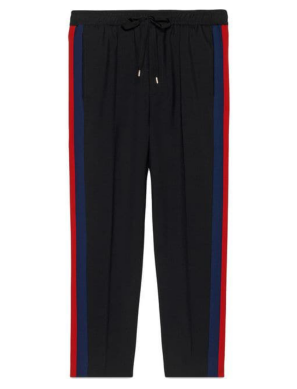

In [11]:
print_photo(pants_path + "/menpant1032.png")

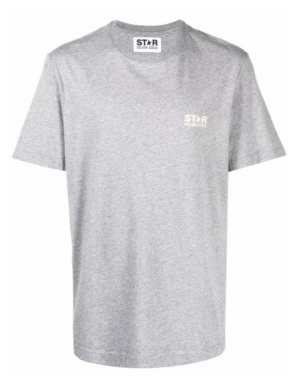

In [12]:
print_photo(tshirts_path + "/m10015.png")

In [12]:
def split_images(source_dir, train_dir, test_dir, test_size=0.2):
    # إنشاء مجلدات الإخراج
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # جميع الصور في المجلد
    images = [f for f in os.listdir(source_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # تقسيم الصور إلى train و test
    train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)

    # نسخ الصور
    for img in train_imgs:
        shutil.copy(os.path.join(source_dir, img), os.path.join(train_dir, img))

    for img in test_imgs:
        shutil.copy(os.path.join(source_dir, img), os.path.join(test_dir, img))

    print(f"✅ {source_dir}: {len(train_imgs)} تدريب - {len(test_imgs)} اختبار")

# 🧵 بلوزات
image_folder_tops = tshirts_path
train_dir_top = '/content/data_split_top/train'
test_dir_top = '/content/data_split_top/test'

# 👖 بناطيل
image_folder_pants = pants_path
train_dir_pants = '/content/data_split_pants/train'
test_dir_pants = '/content/data_split_pants/test'

# ✂️ تقسيم
split_images(image_folder_tops, train_dir_top, test_dir_top)
split_images(image_folder_pants, train_dir_pants, test_dir_pants)


✅ /content/drive/MyDrive/data_tops/tops: 8124 تدريب - 2032 اختبار
✅ /content/drive/MyDrive/data_pants/pants: 6565 تدريب - 1642 اختبار


In [8]:

# مسارات الملفات
pants_train_folder = '/content/data_split_pants/train'    # البنطلونات (train)
tops_train_folder = '/content/data_split_top/train'     # البلايز (train)


# دالة التحضير
def load_and_preprocess_images(folder_path, target_size=(128, 128)):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                img = img.astype('float32') / 255.0  # Normalization
                images.append(img)
    return np.array(images)

# تجهيز كل المجموعات
pants_train_images = load_and_preprocess_images(pants_train_folder)
tops_train_images = load_and_preprocess_images(tops_train_folder)


# طباعة أشكال البيانات للتأكيد
print(f"👖 صور تدريب البناطيل:", pants_train_images.shape)
print(f"👕 صور تدريب البلايز:", tops_train_images.shape)



👖 صور تدريب البناطيل: (6565, 128, 128, 3)
👕 صور تدريب البلايز: (8124, 128, 128, 3)


In [9]:
# دمج البلايز والبناطيل في مجموعة تدريب واحدة
train_images = np.concatenate([pants_train_images, tops_train_images], axis=0)

# طباعة شكل البيانات الجديد
print(f"📦 شكل بيانات التدريب الكاملة:", train_images.shape)


📦 شكل بيانات التدريب الكاملة: (14689, 128, 128, 3)


In [10]:
# 1. Encoder
def build_encoder(latent_dim):
    encoder_inputs = layers.Input(shape=(128, 128, 3))
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    # Sampling Layer
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

# 2. Decoder
def build_decoder(latent_dim):
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(16 * 16 * 128, activation='relu')(decoder_inputs)
    x = layers.Reshape((16, 16, 128))(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

    decoder = Model(decoder_inputs, decoder_outputs, name="decoder")
    return decoder

# 3. بناء الـ VAE مع Loss Function
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer):
        super(VAE, self).compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=(1,2,3)))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [11]:
latent_dim = 32  # حسب اختيارك

# بناء الموديلات
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
vae = VAE(encoder, decoder)

# تحديد الـ optimizer
optimizer = tf.keras.optimizers.Adam()

# تجهيز الموديل للتدريب
vae.compile(optimizer=optimizer)


In [ ]:
vae.fit(train_images, epochs=50, batch_size=64)

In [ ]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        # لازم ترجع الـ output النهائي عشان Keras يعرف كيف يمرر البيانات
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def compile(self, optimizer):
        super(VAE, self).compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=(1,2,3)))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [ ]:
latent_dim = 32
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
vae = VAE(encoder, decoder)

# ضروري لبناء النموذج:
vae(tf.random.normal((1, 128, 128, 3)))

# الحفظ:
vae.save_weights("vae_final.weights.h5")
print("✅ تم حفظ الأوزان بنجاح")


✅ تم حفظ الأوزان بنجاح


555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


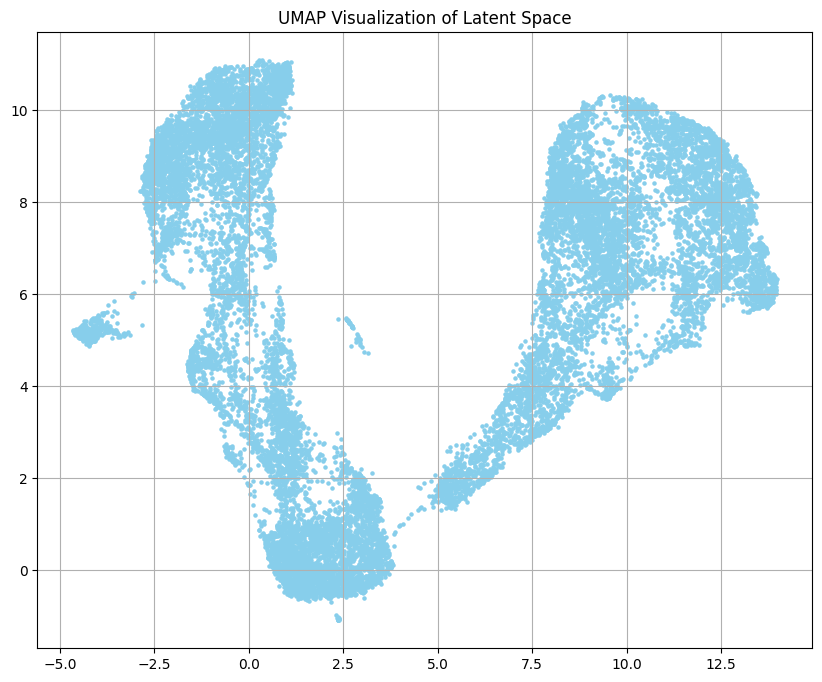

In [ ]:

# latent vectors (z_mean فقط) من encoder
latent_vectors = encoder.predict(train_images)[0]  # shape: (num_images, latent_dim)

# تقليل الأبعاد
embedding = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(latent_vectors)

# رسم النتائج (لون كل نقطة حسب اسم الملف أو اللون السائد لو عندك)
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, c='skyblue')
plt.title("UMAP Visualization of Latent Space")
plt.grid(True)
plt.show()


In [ ]:
# افترض عندك صور البلايز بعد Preprocessing باسم tops_train_images
tops_latent_vectors = encoder.predict(tops_train_images)[0]  # نأخذ z_mean
print("شكل التمثيل العددي للبلايز:", tops_latent_vectors.shape)


255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
شكل التمثيل العددي للبلايز: (8159, 32)


In [ ]:


def find_best_matching_tops(pants_img_array, top_latents, tops_paths):
    z_mean, _, _ = encoder.predict(np.expand_dims(pants_img_array, axis=0))
    distances = euclidean_distances(z_mean, top_latents)
    best_index = np.argmin(distances)
    return tops_paths[best_index]


In [ ]:


def find_best_matching_n_tops(pants_img_array, top_latents, tops_paths):
    z_mean, _, _ = encoder.predict(np.expand_dims(pants_img_array, axis=0))
    distances = euclidean_distances(z_mean, top_latents)
    best_index = np.argsort(distances[0])[:5]
    return np.array(tops_paths)[best_index]


In [ ]:

tops_paths = []
tops_folder = '/content/data_split_top/train' #'/content/pants_cut/train'  # تأكد من مسار مجلد البلايز

for filename in sorted(os.listdir(tops_folder)):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        tops_paths.append(os.path.join(tops_folder, filename))

print(f"عدد البلايز:", len(tops_paths))

عدد البلايز: 8159


In [ ]:
'/content/data_split_pants/test/menpant1007.png'

'/content/data_split_pants/test/menpant1007.png'

In [ ]:
pants_img_path ='/content/pants.jpg' # مسار بنطالك الجديدة
pants_img = cv2.imread(pants_img_path)
pants_img = cv2.cvtColor(pants_img, cv2.COLOR_BGR2RGB)
pants_img = cv2.resize(pants_img, (128, 128))
pants_img = pants_img.astype('float32') / 255.0


In [ ]:
best_tops_path = find_best_matching_tops(pants_img, tops_latent_vectors, tops_paths)
print("أفضل بنطلون للبلوزة:", best_tops_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
أفضل بنطلون للبلوزة: /content/data_split_top/train/m10014.png


In [ ]:
best_tops_path = find_best_matching_n_tops(pants_img, tops_latent_vectors, tops_paths)
print("أفضل بلوزة للبنطلون:", best_tops_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
أفضل بنطلون للبلوزة: ['/content/data_split_top/train/m10014.png'
 '/content/data_split_top/train/m8351.png'
 '/content/data_split_top/train/m3179.png'
 '/content/data_split_top/train/m7040.png'
 '/content/data_split_top/train/m3605.png']


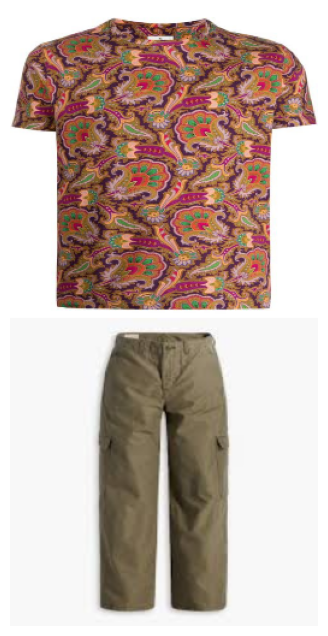

In [ ]:
def merge_top_bottom(top_img_path, bottom_img_path, output_size=(256, 512)):
    top_img = cv2.imread(top_img_path)
    bottom_img = cv2.imread(bottom_img_path)

    top_img = cv2.cvtColor(top_img, cv2.COLOR_BGR2RGB)
    bottom_img = cv2.cvtColor(bottom_img, cv2.COLOR_BGR2RGB)

    top_img = cv2.resize(top_img, (output_size[0], output_size[1]//2))
    bottom_img = cv2.resize(bottom_img, (output_size[0], output_size[1]//2))

    combined_img = np.vstack((top_img, bottom_img))
    return combined_img

# عرض النتيجة
outfit_image1 = merge_top_bottom(best_tops_path[3], pants_img_path)
outfit_image2 = merge_top_bottom(best_tops_path[4], pants_img_path)
outfit_image3 = merge_top_bottom(best_tops_path[2], pants_img_path)

import matplotlib.pyplot as plt
plt.figure(figsize=(4,8))
plt.imshow(outfit_image1)
plt.axis('off')
plt.show()


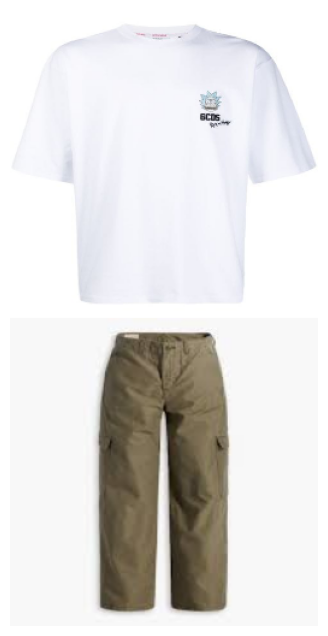

In [ ]:
plt.figure(figsize=(4,8))
plt.imshow(outfit_image2)
plt.axis('off')
plt.show()

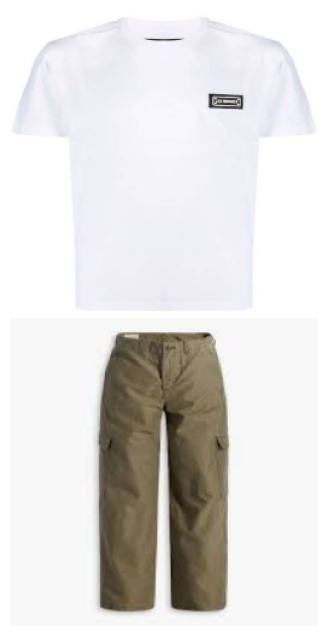

In [ ]:
plt.figure(figsize=(4,8))
plt.imshow(outfit_image3)
plt.axis('off')
plt.show()

In [ ]:


def zip_entire_folder(folder_path, output_zip_path):
    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                abs_path = os.path.join(root, file)
                rel_path = os.path.relpath(abs_path, start=folder_path)  # يحافظ على الهيكل الداخلي
                zipf.write(abs_path, arcname=rel_path)
    print(f"✅ تم ضغط المجلد: {folder_path} ➜ إلى: {output_zip_path}")


In [ ]:
zip_entire_folder('/content/data_split_pants', 'data_split_pants.zip')

zip_entire_folder('/content/data_split_top', 'data_split_top.zip')

✅ تم ضغط المجلد: /content/data_split_pants ➜ إلى: data_split_pants.zip
✅ تم ضغط المجلد: /content/data_split_top ➜ إلى: data_split_top.zip
